In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/netflow/CIDDS-001/traffic/mixed.csv', index_col='DATE')
df.drop(['FLAGS', 'CLASS', 'ATTACK_ID', 'ATTACK_DESCRIPTION'], axis=1, inplace=True)

df = df.sample(frac=1).iloc[:1000]

df['SRC'] = df['SRC_IP_ADDR'].str.cat(df['SRC_PORT'].astype(str), sep=':')
df['DST'] = df['DST_IP_ADDR'].str.cat(df['DST_PORT'].astype(str), sep=':')
df.drop(['SRC_IP_ADDR', 'SRC_PORT', 'DST_IP_ADDR', 'DST_PORT'], axis=1, inplace=True)
df.head()

DURATION PROTOCOL  PACKETS    BYTES  TOS ATTACK_TYPE  \
DATE                                                                            
2017-04-05 19:43:14.807     8.514    TCP         19   3185.0    0      benign   
2017-03-24 12:01:32.340     0.000    TCP          1     66.0    0      benign   
2017-03-22 07:16:09.247     0.001    UDP          2    168.0    0      benign   
2017-03-25 21:42:45.250     0.001    TCP          2    174.0    0      benign   
2017-03-28 14:53:57.015     0.305    TCP         22  36210.0   32      benign   

                             TYPE                  SRC                  DST  
DATE                                                                         
2017-04-05 19:43:14.807  internal        EXT_SERVER:22       10006_27:64465  
2017-03-24 12:01:32.340  internal  192.168.220.5:40397         11464_135:80  
2017-03-22 07:16:09.247  internal  192.168.220.4:45265               DNS:53  
2017-03-25 21:42:45.250  internal  192.168.200.4:56338    192.168.100.5:445  
2017-03-28 14:53:57.015  internal          10082_30:80  192.168.200.4:40706

In [3]:
from sklearn.preprocessing import LabelEncoder

def label_encode(series_to_encode):
    lb_e = LabelEncoder()
    return lb_e, lb_e.fit_transform(series_to_encode)

FEATURES_TO_LABELENCODE = ['PROTOCOL', 'TYPE', 'TOS', 'ATTACK_TYPE', 'SRC', 'DST']
encoders = {}

for f in FEATURES_TO_LABELENCODE:
    print("Processing feature {}".format(f))
    encoders[f], df[f] = label_encode(df[f])

Processing feature PROTOCOL
Processing feature TYPE
Processing feature TOS
Processing feature ATTACK_TYPE
Processing feature SRC
Processing feature DST


In [4]:
df['ATTACK_TYPE'].value_counts()

0    836
2    152
3     11
1      1
Name: ATTACK_TYPE, dtype: int64

In [5]:
pd.Series(encoders['ATTACK_TYPE'].inverse_transform(df['ATTACK_TYPE'])).value_counts()

benign        836
dos           152
portScan       11
bruteForce      1
dtype: int64

In [27]:
LABELS_COLORS_MAP = {
    0: "#299e50", 
    1: "#1900ff", 
    2: "#ff0000",
    3: "#fff700",
    4: "#1500ff"
}

COLORS_LABELS_MAP = {
    "#299e50": 0,
    "#1900ff": 1,
    "#ff0000": 2,
    "#fff700": 3,
    "#1500ff": 4
}

LABELS_ENCODINGS_MAP = {
    0: "benign",
    1: "bruteForce",
    2: "dos",
    3: "pingScan",
    4: "portScan"
}

In [7]:
nodes_df = pd.concat([
    df[['SRC', 'TYPE']].rename(columns={'SRC': 'ID'}).reset_index(drop=True), 
    df[['DST', 'TYPE']].rename(columns={'DST': 'ID'}).reset_index(drop=True)
]).drop_duplicates()

nodes_df['COLOR'] = np.where(nodes_df['TYPE'] == 0, "#107be6", "#000000")
nodes_df.drop('TYPE', axis=1, inplace=True)

nodes_df.head()

ID    COLOR
0  686  #000000
1  603  #000000
2  578  #000000
3  268  #000000
4   55  #000000

In [8]:
edges_df = df[['SRC', 'DST', 'DURATION', 'PROTOCOL', 'PACKETS', 'BYTES', 'TOS', 'ATTACK_TYPE']]
edges_df['SPEED'] = edges_df['BYTES'] / edges_df['DURATION']
edges_df['SPEED'] = edges_df['SPEED'].replace([np.inf, -np.inf], 0.01)

edges_df.reset_index(inplace=True, drop=True)

edges_df.head()

SRC  DST  DURATION  PROTOCOL  PACKETS    BYTES  TOS  ATTACK_TYPE  \
0  686   13     8.514         1       19   3185.0    0            0   
1  603  207     0.000         1        1     66.0    0            0   
2  578  750     0.001         2        2    168.0    0            0   
3  268  264     0.001         1        2    174.0    0            0   
4   55  268     0.305         1       22  36210.0    1            0   

           SPEED  
0     374.089735  
1       0.010000  
2  168000.000000  
3  174000.000000  
4  118721.311475

In [9]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('notebooks'), '..'))

from graphs.multigraph import Multigraph
from embeddings.b_node2vec import Node2VecBaseline
from dim_reducers.b_tsne import tSNEBaseline

In [10]:
multigraph = Multigraph()

multigraph.add_nodes(nodes_df)
multigraph.add_edges(edges_df)

multigraph.plot()

# Essaie **1**
changement des parametres node2vec
1000 - 80 - 100

In [15]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 1000, 80)
embeddings.fit()

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)

dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.89s/it]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 772 samples in 0.000s...
[t-SNE] Computed neighbors for 772 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 772 / 772
[t-SNE] Mean sigma: 6.574274
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.139374
[t-SNE] KL divergence after 1000 iterations: 1.224520


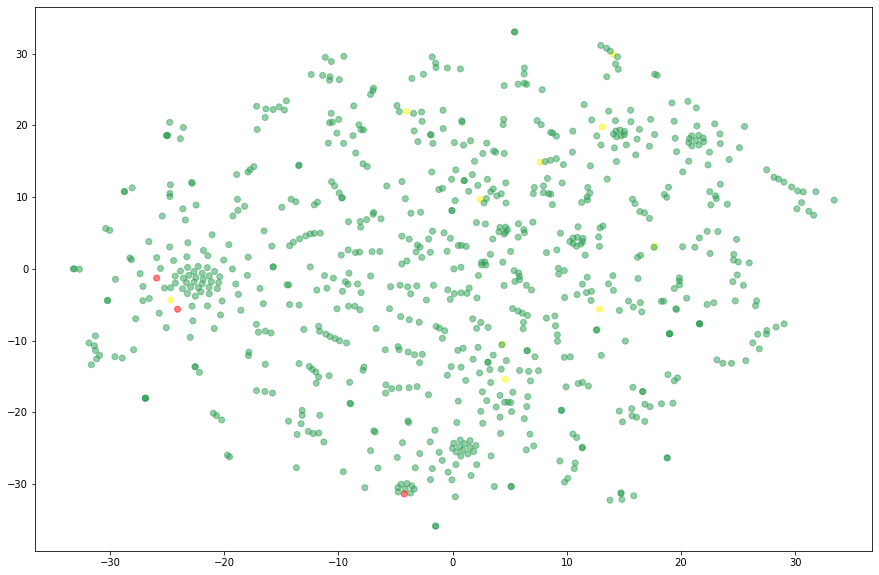

In [16]:
tsne.plot(colors)

# Essaie **2**
changement des parametres node2vec
1000 - 50 - 50

In [17]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 1000, 50, 50)
embeddings.fit()

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)

dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 772 samples in 0.001s...
[t-SNE] Computed neighbors for 772 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 772 / 772
[t-SNE] Mean sigma: 6.623140
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.722191
[t-SNE] KL divergence after 1000 iterations: 1.032101


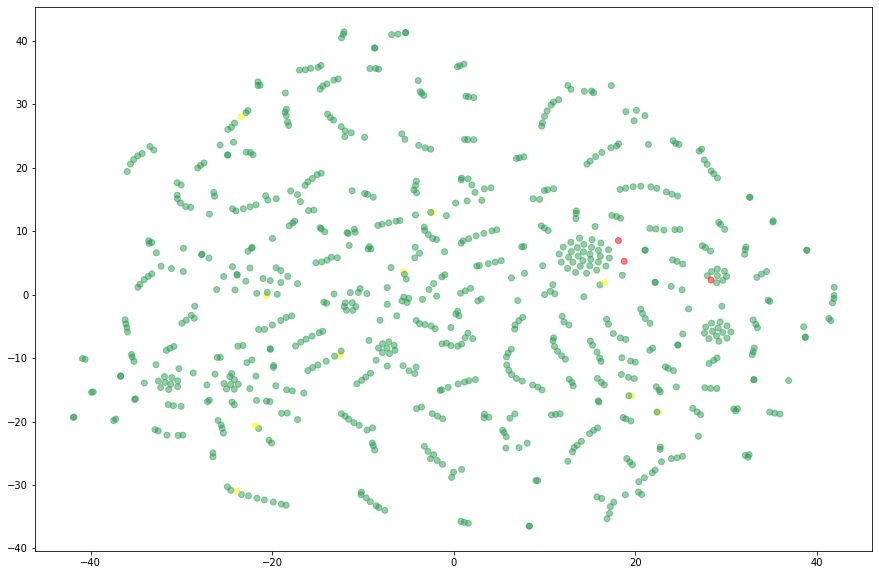

In [18]:
tsne.plot(colors)

# Essaie *3*
changement des parametres node2vec
4 - 80 - 100 

In [19]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 4, 80, 100)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.89s/it]


In [20]:
embeddings.fit()
embeddings.node_embeddings

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)

dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 772 samples in 0.000s...
[t-SNE] Computed neighbors for 772 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 772 / 772
[t-SNE] Mean sigma: 3.093905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.024540
[t-SNE] KL divergence after 1000 iterations: 0.614799


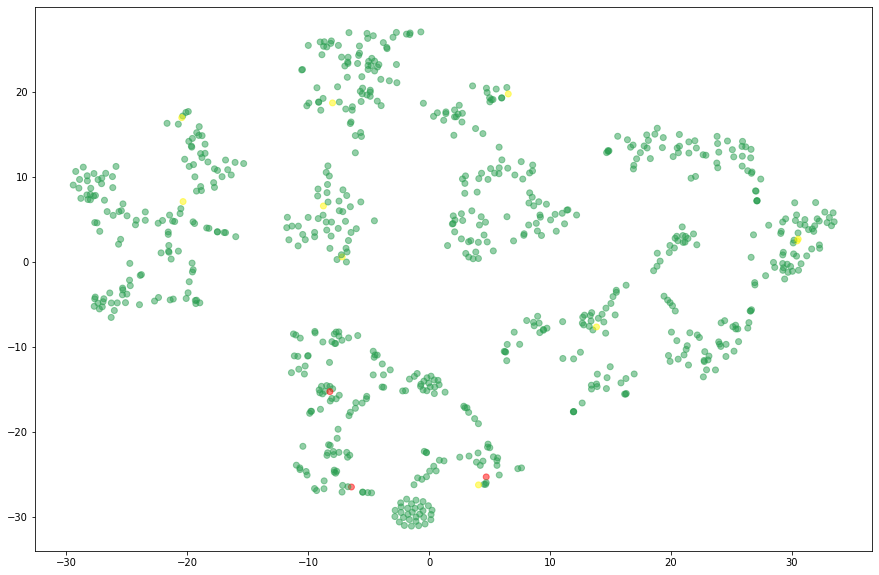

In [21]:
tsne.plot(colors)

# Essaie *4*
changement des parametres node2vec
4 - 50 - 50 

In [22]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 4,50, 100)
embeddings.fit()

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)

dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 772 samples in 0.000s...
[t-SNE] Computed neighbors for 772 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 772 / 772
[t-SNE] Mean sigma: 2.743223
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.243896
[t-SNE] KL divergence after 1000 iterations: 0.575841


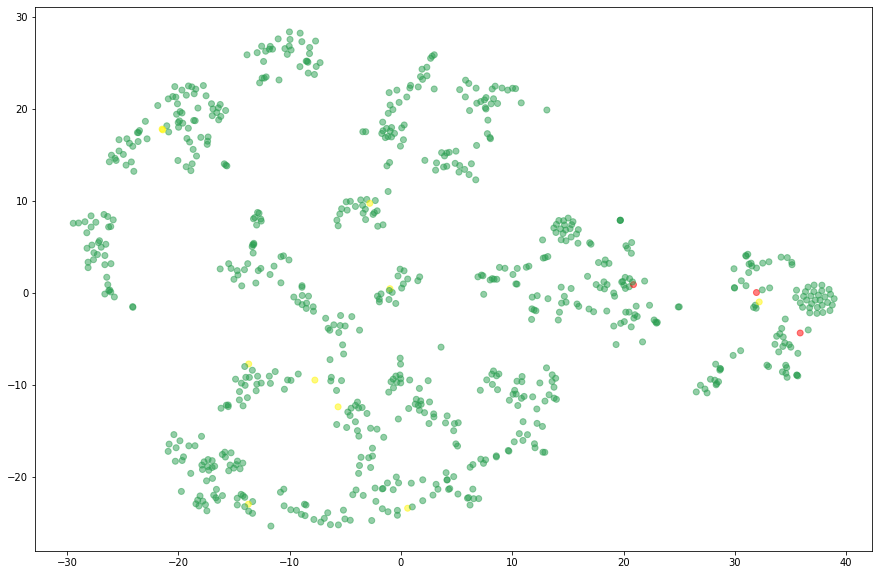

In [23]:
tsne.plot(colors)

# Test *tsne*
changement des parametres TSNE


In [11]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, dimensions=4, walk_length=80, num_walks=100)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.95s/it]


In [12]:
embeddings.fit()

In [13]:
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 772 samples in 0.002s...
[t-SNE] Computed neighbors for 772 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 772 / 772
[t-SNE] Mean sigma: 3.066122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.730019
[t-SNE] KL divergence after 1000 iterations: 0.643815


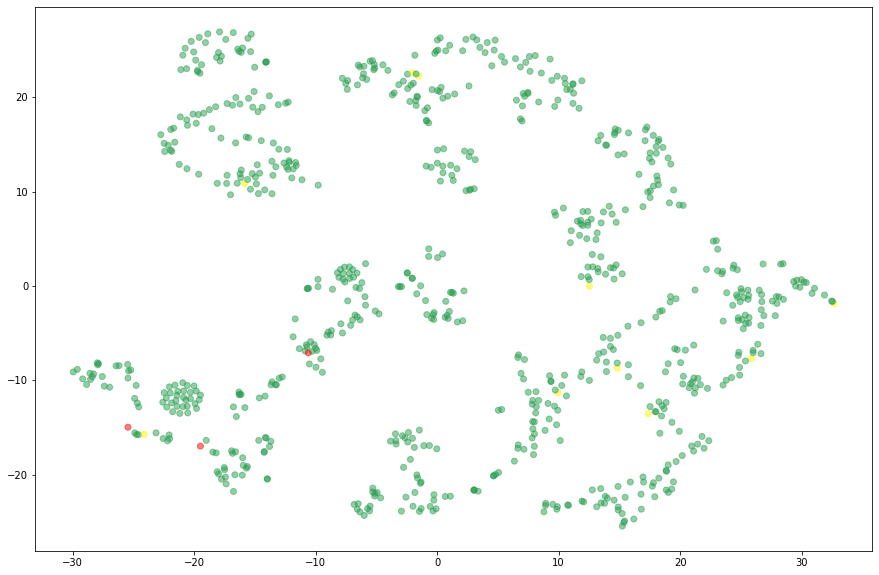

In [14]:
tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)

tsne.plot(colors)

# **Evaluation Score**

In [28]:
Xy = pd.DataFrame(tsne.reduced_vectors)
Xy['ID'] = embeddings.node_embeddings_id
Xy['LABEL'] = [COLORS_LABELS_MAP[l] for l in colors]
Xy.head()

0          1   ID  LABEL
0  35.875610  -4.385493  259      2
1 -21.044701  18.134045  684      0
2  31.944788   0.011076  265      2
3  16.765432   1.770106  750      0
4 -16.582560 -21.385143  686      0

In [29]:
X = Xy[[0, 1]]
y = Xy['LABEL']

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)

clf.fit(X_train, y_train)

c:\users\driss\miniconda3\envs\ids-ml\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [34]:
from models import random, procedural1, procedural2, procedural3
from metrics import accuracy, confusion_matrix, recall

In [35]:
metrics = [accuracy, recall, confusion_matrix]

	 Accuracy Score: 0.9741935483870968
	 Recall: 0.9741935483870968
	 Confusion Matrix:


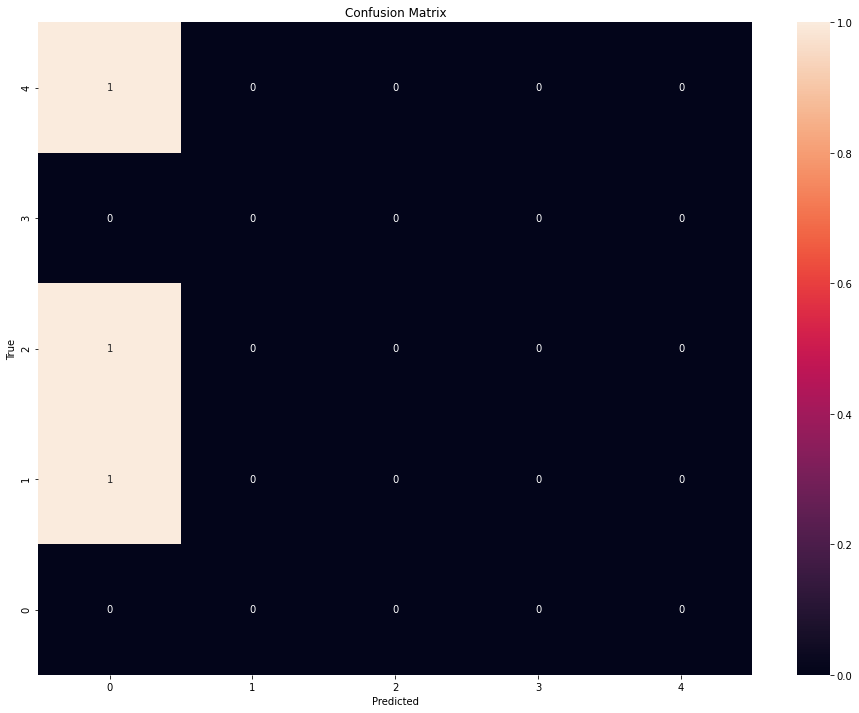

In [36]:
for metric in metrics:
        metric_name = metric.name
    
        if metric_name == 'Confusion Matrix':
            print("\t {}:".format(metric_name))
            _ = metric.plot(Y_true=y_test, 
                            Y_predicted=clf.predict(X_test), 
                            labels=[0, 1, 2, 3, 4]
                           )
        else:
            print("\t {}: {}".format(metric_name, metric.evaluate(Y_true=y_test, Y_predicted=clf.predict(X_test))))